#### Model v2 -- to run code below I had to switch into a different virtual environment and install just these packages

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, ConcatDataset
import numpy as np
from skimage.filters import gabor_kernel
import copy
import matplotlib.pyplot as plt
from torch.utils.data import random_split
import modeling

## do 16 16 
### do percent change in accuracy instead of accuracy differences 

In [2]:
transform_cifar = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

batch_size = 64

## Load CIFAR-10 dataset (training = 50,000 images, test = 10,000 images)

cifar_trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_cifar)
cifar_testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_cifar)
cifar_trainset, cifar_valset = random_split(cifar_trainset, [int(len(cifar_trainset) * 0.9), int(len(cifar_trainset) * 0.1)])
cifar_train_loader = DataLoader(cifar_trainset, batch_size=batch_size, shuffle=True)    # shape = (40000, 1, 32, 32)
cifar_val_loader = DataLoader(cifar_valset, batch_size=batch_size, shuffle=False)
cifar_test_loader = DataLoader(cifar_testset, batch_size=batch_size, shuffle=False)

# gabor_trainset = modeling.GaborDataset(num_images=45000, img_size=32, orientations=10, frequencies=[0.08, 0.04], add_noise=True, noise_level=0.1)
# gabor_valset = modeling.GaborDataset(num_images=5000, img_size=32, orientations=10, frequencies=[0.08, 0.04], add_noise=True, noise_level=0.1)
# gabor_testset = modeling.GaborDataset(num_images=10000, img_size=32, orientations=10, frequencies=[0.08, 0.04], add_noise=True, noise_level=0.1)
gabor_trainset = modeling.GaborDatasetNoisy(
    num_images=45000,
    img_size=32,
    orientations=10,
    frequencies=[0.08, 0.04],
    noise_level=0.2,
    orientation_jitter=0.15,
    frequency_jitter=0.015,
    sigma_range=(8, 22),
    offset_jitter=7,
    seed=1,
)
gabor_valset = modeling.GaborDatasetNoisy(
    num_images=5000,
    img_size=32,
    orientations=10,
    frequencies=[0.08, 0.04],
    noise_level=0.2,
    orientation_jitter=0.15,
    frequency_jitter=0.015,
    sigma_range=(8, 22),
    offset_jitter=7,
    seed=2,
)
gabor_testset = modeling.GaborDatasetNoisy(
    num_images=10000,
    img_size=32,
    orientations=10,
    frequencies=[0.08, 0.04],
    noise_level=0.2,
    orientation_jitter=0.15,
    frequency_jitter=0.015,
    sigma_range=(8, 22),
    offset_jitter=7,
    seed=3,
)
gabor_train_loader = DataLoader(gabor_trainset, batch_size=batch_size, shuffle=True)
gabor_val_loader = DataLoader(gabor_valset, batch_size=batch_size, shuffle=False)
gabor_test_loader = DataLoader(gabor_testset, batch_size=batch_size, shuffle=False)

assert len(cifar_trainset) + len(cifar_valset) == 50000
assert len(gabor_trainset) == len(cifar_trainset)
assert len(gabor_valset) == len(cifar_valset)
assert len(gabor_testset) == len(cifar_testset)

combined_trainset = ConcatDataset([cifar_trainset, gabor_trainset])
combined_loader = DataLoader(combined_trainset, batch_size=batch_size, shuffle=True)
combined_valset = ConcatDataset([cifar_valset, gabor_valset])
combined_val_loader = DataLoader(combined_valset, batch_size=batch_size, shuffle=True) # need to shuffle val set too because of concatdataset

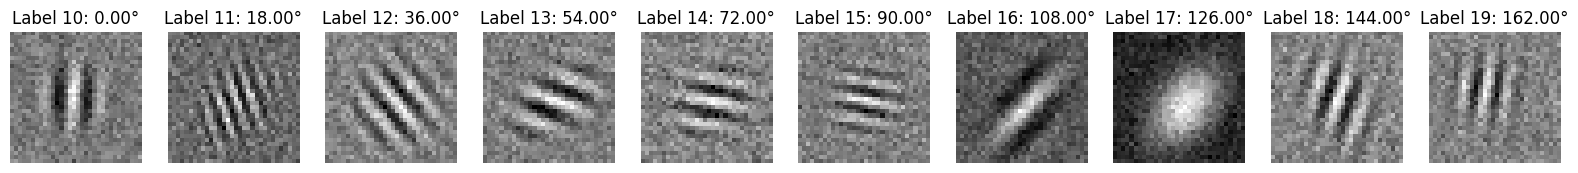

In [3]:
fig, axs = plt.subplots(1, 10, figsize=(20, 5))
orientations = np.linspace(0, np.pi, 10, endpoint=False)
orientations_deg = orientations * 180 / np.pi
gabor_valset = modeling.GaborDatasetNoisy(
    num_images=10,
    img_size=32,
    orientations=10,
    frequencies=[0.08, 0.04],
    noise_level=0.15,
    orientation_jitter=0.1,
    frequency_jitter=0.015,
    sigma_range=(8, 22),
    offset_jitter=5,
    seed=43,
)

for i in range(10):
    axs[i].imshow(gabor_valset[i][0].squeeze(), cmap='gray')
    axs[i].set_title(f'Label {gabor_valset[i][1]}: {orientations_deg[gabor_valset[i][1] - 10]:.2f}°')
    axs[i].axis('off')



In [4]:
model = modeling.ConvNet(in_channels=1, height=32, width=32)
model, train_losses, val_losses, train_losses_epoch, val_losses_epoch, gabor_vals, cifar_vals = modeling.train_model(
    model, 
    train_loader=combined_loader,
    batch_size=64,
    probe_size=64,
    val_dataset=combined_valset,
    num_epochs=50,
    early_stopping=True,
    )

Training model with tag: 2025_10_21_09:47:44


Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Batches in epoch #1:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [1/50]Training Loss: 4.6146Validation Loss: 4.6138


Batches in epoch #2:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [2/50]Training Loss: 1.9589Validation Loss: 2.1230


Batches in epoch #3:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [3/50]Training Loss: 1.7652Validation Loss: 2.0527


Batches in epoch #4:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [4/50]Training Loss: 1.5869Validation Loss: 2.0089


Batches in epoch #5:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [5/50]Training Loss: 1.5024Validation Loss: 2.0352
Early stopping triggered: validation loss increased significantly 2.0352 -> 2.0917.


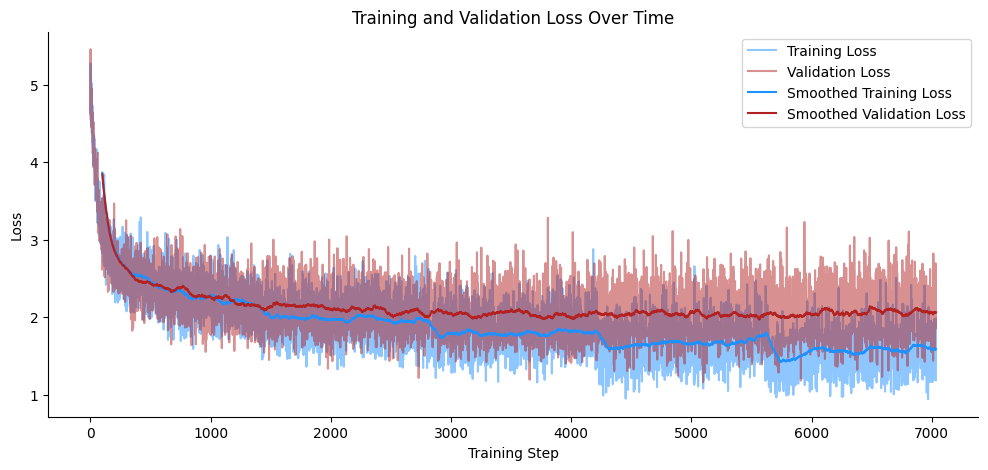

In [5]:
fig, axs = plt.subplots(1, 1, figsize=(12, 5))
axs.plot(train_losses, label="Training Loss", color='dodgerblue', alpha=0.5)
axs.plot(val_losses, label="Validation Loss", color='firebrick', alpha=0.5)

# plot smoothed losses
window_size = 100
train_losses_smooth = np.convolve(train_losses, np.ones(window_size)/window_size, mode='valid')
val_losses_smooth = np.convolve(val_losses, np.ones(window_size)/window_size, mode='valid')
axs.plot(range(window_size - 1, len(train_losses)), train_losses_smooth, label="Smoothed Training Loss", color='dodgerblue')
axs.plot(range(window_size - 1, len(val_losses)), val_losses_smooth, label="Smoothed Validation Loss", color='firebrick')
axs.set_xlabel("Training Step")
axs.set_ylabel("Loss")
axs.set_title("Training and Validation Loss Over Time")
axs.legend()
# axs.set_xlim(0, 10000)
plt.gca().spines[['top', 'right']].set_visible(False)


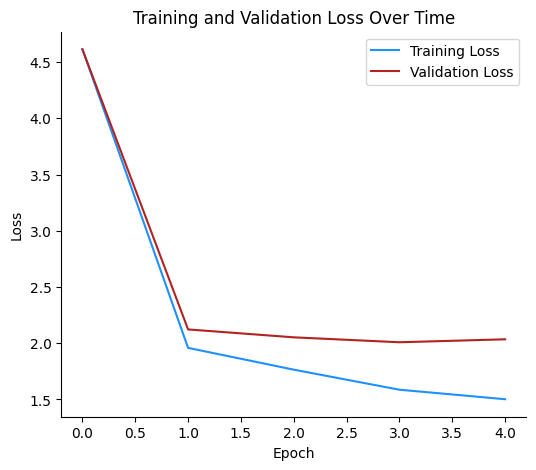

In [6]:
fig, axs = plt.subplots(1, 1, figsize=(6, 5))
axs.plot(train_losses_epoch, label="Training Loss", color='dodgerblue')
axs.plot(val_losses_epoch[:-1], label="Validation Loss", color='firebrick')

axs.set_xlabel("Epoch")
axs.set_ylabel("Loss")
axs.set_title("Training and Validation Loss Over Time")
axs.legend()
# axs.set_xlim(0, 10000)
plt.gca().spines[['top', 'right']].set_visible(False)


Text(0.5, 1.0, 'Validation Accuracy over Epochs')

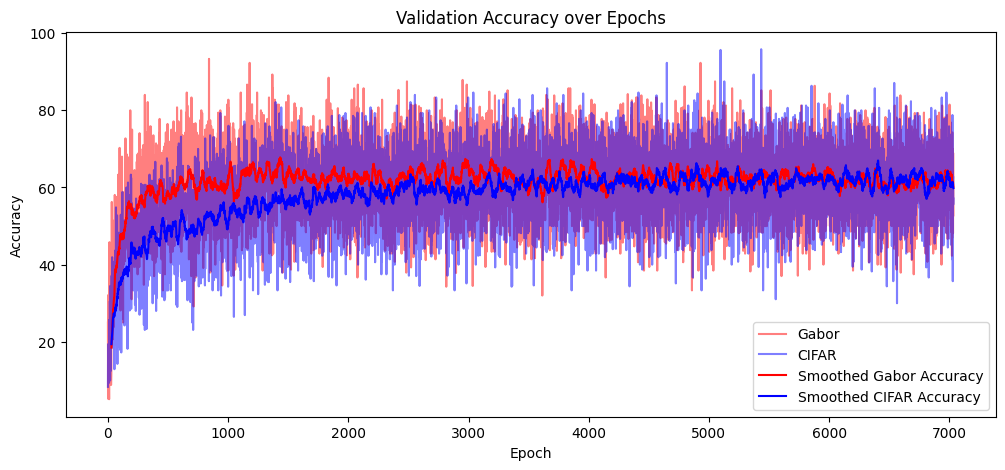

In [7]:
plt.figure(figsize=(12, 5))

plt.plot(gabor_vals, label='Gabor', color='red', alpha=0.5)
plt.plot(cifar_vals, label='CIFAR', color='blue', alpha=0.5)

# plot smoothed accuracies
window_size = 30
gabor_vals_smooth = np.convolve(gabor_vals, np.ones(window_size)/window_size, mode='valid')
plt.plot(range(window_size - 1, len(gabor_vals)), gabor_vals_smooth, label="Smoothed Gabor Accuracy", color='red')
cifar_vals_smooth = np.convolve(cifar_vals, np.ones(window_size)/window_size, mode='valid')
plt.plot(range(window_size - 1, len(cifar_vals)), cifar_vals_smooth, label="Smoothed CIFAR Accuracy", color='blue')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
# plt.xlim(-10, 200)
plt.title('Validation Accuracy over Epochs')

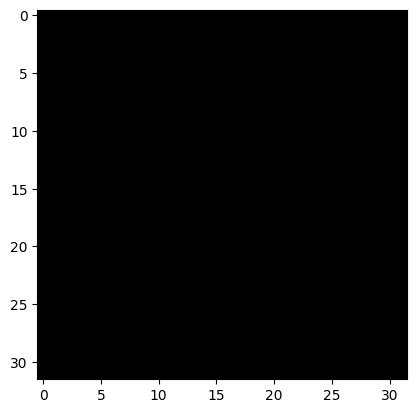

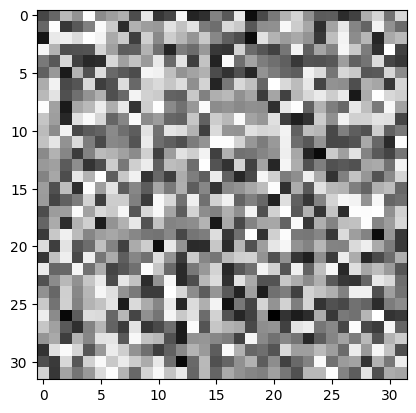

In [38]:
import torch.nn as nn
x = torch.rand((16, 32, 32, 32))
id = nn.Identity()
y = id(x)

# print(x - y)
plt.imshow((x-y)[0][0], cmap='gray')

# add noise
id = torch.randn((16, 32, 32, 32)) * 0.1
y = id * x

plt.figure()
plt.imshow((y - x)[0][0], cmap='gray')

In [8]:
noise_results = {
    'noise_level': [],
    'noisy1_gabor_acc': [],
    'noisy1_cifar_acc': [],
    'noisy2_gabor_acc': [],
    'noisy2_cifar_acc': [],
}
noise_levels = np.arange(0, 1.05, 0.05)

for noise in noise_levels:
    noisy_model = copy.deepcopy(model)

    noisy_model.eval()
    noisy_model.skip.noise_level = noise
    noisy1_gabor_acc = modeling.evaluate_gabor_accuracy(noisy_model, gabor_test_loader)
    noisy1_cifar_acc = modeling.evaluate_cifar_accuracy(noisy_model, cifar_test_loader)

    noisy_model = copy.deepcopy(model)
    noisy_model.eval()
    noisy_model.skip.noise_level = 0
    noisy_middle_model = modeling.add_noise_to_middle_layer(noisy_model, noise_level=noise)
    noisy2_gabor_acc = modeling.evaluate_gabor_accuracy(noisy_model, gabor_test_loader)
    noisy2_cifar_acc = modeling.evaluate_cifar_accuracy(noisy_model, cifar_test_loader)

    noise_results['noise_level'].append(noise)
    noise_results['noisy1_gabor_acc'].append(noisy1_gabor_acc)
    noise_results['noisy1_cifar_acc'].append(noisy1_cifar_acc)
    noise_results['noisy2_gabor_acc'].append(noisy2_gabor_acc)
    noise_results['noisy2_cifar_acc'].append(noisy2_cifar_acc)


In [9]:
import pandas as pd
noise_results_df = pd.DataFrame(noise_results)
noise_results_df

,noise_level,noisy1_gabor_acc,noisy1_cifar_acc,noisy2_gabor_acc,noisy2_cifar_acc
0,0.00,60.99,60.39,60.99,60.39
1,0.05,59.99,54.17,61.62,59.61
2,0.10,58.46,45.39,57.43,53.39
3,0.15,56.07,39.60,59.20,54.97
4,0.20,53.26,35.13,57.26,47.51
5,0.25,50.52,31.75,54.35,30.57
6,0.30,47.87,28.88,51.29,31.86
7,0.35,45.28,26.34,45.02,27.74
8,0.40,42.53,24.25,49.32,31.54
9,0.45,39.57,22.66,36.08,18.71


In [10]:
noise_results_df['noisy1_gabor_pctchange'] = (noise_results_df['noisy1_gabor_acc'] - noise_results_df['noisy1_gabor_acc'].iloc[0]) / noise_results_df['noisy1_gabor_acc'].iloc[0] * 100
noise_results_df['noisy2_gabor_pctchange'] = (noise_results_df['noisy2_gabor_acc'] - noise_results_df['noisy2_gabor_acc'].iloc[0]) / noise_results_df['noisy2_gabor_acc'].iloc[0] * 100
noise_results_df['noisy1_cifar_pctchange'] = (noise_results_df['noisy1_cifar_acc'] - noise_results_df['noisy1_cifar_acc'].iloc[0]) / noise_results_df['noisy1_cifar_acc'].iloc[0] * 100
noise_results_df['noisy2_cifar_pctchange'] = (noise_results_df['noisy2_cifar_acc'] - noise_results_df['noisy2_cifar_acc'].iloc[0]) / noise_results_df['noisy2_cifar_acc'].iloc[0] * 100

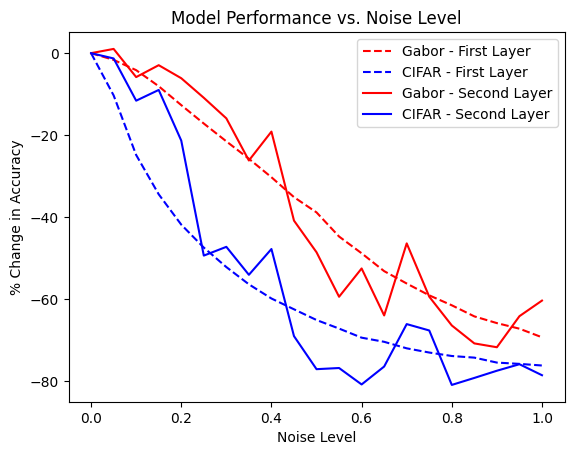

In [11]:
import seaborn as sns
sns.lineplot(data=noise_results_df, x='noise_level', y='noisy1_gabor_pctchange', label='Gabor - First Layer', color='red', linestyle='--')
sns.lineplot(data=noise_results_df, x='noise_level', y='noisy1_cifar_pctchange', label='CIFAR - First Layer', color='blue', linestyle='--')

sns.lineplot(data=noise_results_df, x='noise_level', y='noisy2_gabor_pctchange', label='Gabor - Second Layer', color='red')
sns.lineplot(data=noise_results_df, x='noise_level', y='noisy2_cifar_pctchange', label='CIFAR - Second Layer', color='blue')

plt.xlabel('Noise Level')
plt.ylabel('% Change in Accuracy')
plt.title('Model Performance vs. Noise Level')
plt.legend()

In [39]:
#### stability plots ####
results = {
    'idx': [],
    'gabor_acc': [],
    'cifar_acc': [],
}

noise_results = {
    'idx': [],
    'noise_level': [],
    'noisy1_gabor_acc': [],
    'noisy1_cifar_acc': [],
    'noisy2_gabor_acc': [],
    'noisy2_cifar_acc': [],
}
noise_levels = np.arange(0, 1.05, 0.05)

for i in range(20):
    model = modeling.ConvNet(in_channels=1, height=32, width=32)
    model, losses, val_losses, _, _, _, _ = modeling.train_model(
        model, 
        combined_loader, 
        val_dataset=combined_valset, 
        batch_size=64, 
        probe_size=64, 
        num_epochs=50, 
        early_stopping=True
    )

    gabor_acc = modeling.evaluate_gabor_accuracy(model, gabor_test_loader)
    cifar_acc = modeling.evaluate_cifar_accuracy(model, cifar_test_loader)

    results['idx'].append(i)
    results['gabor_acc'].append(gabor_acc)
    results['cifar_acc'].append(cifar_acc)

    for noise in noise_levels:
        noisy_model = copy.deepcopy(model)

        noisy_model.eval()
        noisy_model.skip.noise_level = noise
        noisy_first_model = modeling.add_noise_to_first_layer(noisy_model, noise_level=noise)
        noisy1_gabor_acc = modeling.evaluate_gabor_accuracy(noisy_model, gabor_test_loader)
        noisy1_cifar_acc = modeling.evaluate_cifar_accuracy(noisy_model, cifar_test_loader)

        noisy_model = copy.deepcopy(model)
        noisy_model.eval()
        noisy_model.skip.noise_level = 0
        noisy_middle_model = modeling.add_noise_to_middle_layer(noisy_model, noise_level=noise)
        noisy2_gabor_acc = modeling.evaluate_gabor_accuracy(noisy_model, gabor_test_loader)
        noisy2_cifar_acc = modeling.evaluate_cifar_accuracy(noisy_model, cifar_test_loader)

        noise_results['idx'].append(i)
        noise_results['noise_level'].append(noise)
        noise_results['noisy1_gabor_acc'].append(noisy1_gabor_acc)
        noise_results['noisy1_cifar_acc'].append(noisy1_cifar_acc)
        noise_results['noisy2_gabor_acc'].append(noisy2_gabor_acc)
        noise_results['noisy2_cifar_acc'].append(noisy2_cifar_acc)
    
    print(f'Iteration {i+1}/20 complete.')

Training model with tag: 2025_10_21_10:03:05


Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Batches in epoch #1:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [1/50]Training Loss: 4.6132Validation Loss: 4.6127


Batches in epoch #2:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [2/50]Training Loss: 2.0043Validation Loss: 2.1617


Batches in epoch #3:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [3/50]Training Loss: 1.7990Validation Loss: 2.1091


Batches in epoch #4:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [4/50]Training Loss: 1.6070Validation Loss: 2.0288


Batches in epoch #5:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [5/50]Training Loss: 1.4738Validation Loss: 2.0116


Batches in epoch #6:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [6/50]Training Loss: 1.3875Validation Loss: 2.0373
Early stopping triggered: validation loss increased significantly 2.0373 -> 2.1270.
Iteration 1/20 complete.
Training model with tag: 2025_10_21_10:04:50


Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Batches in epoch #1:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [1/50]Training Loss: 4.6148Validation Loss: 4.6139


Batches in epoch #2:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [2/50]Training Loss: 2.0280Validation Loss: 2.1888


Batches in epoch #3:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [3/50]Training Loss: 1.7693Validation Loss: 2.0449


Batches in epoch #4:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [4/50]Training Loss: 1.6091Validation Loss: 1.9896


Batches in epoch #5:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [5/50]Training Loss: 1.5150Validation Loss: 2.0193


Batches in epoch #6:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [6/50]Training Loss: 1.4060Validation Loss: 2.0294


Batches in epoch #7:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [7/50]Training Loss: 1.3080Validation Loss: 2.0638
Early stopping triggered: validation loss increased significantly 2.0638 -> 2.1416.
Iteration 2/20 complete.
Training model with tag: 2025_10_21_10:06:48


Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Batches in epoch #1:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [1/50]Training Loss: 4.6195Validation Loss: 4.6192


Batches in epoch #2:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [2/50]Training Loss: 2.0398Validation Loss: 2.2205


Batches in epoch #3:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [3/50]Training Loss: 1.7472Validation Loss: 2.0566


Batches in epoch #4:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [4/50]Training Loss: 1.6109Validation Loss: 2.0103


Batches in epoch #5:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [5/50]Training Loss: 1.5039Validation Loss: 2.0393
Early stopping triggered: validation loss increased significantly 2.0393 -> 2.0926.
Iteration 3/20 complete.
Training model with tag: 2025_10_21_10:08:22


Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Batches in epoch #1:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [1/50]Training Loss: 4.6214Validation Loss: 4.6246


Batches in epoch #2:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [2/50]Training Loss: 1.9917Validation Loss: 2.1560


Batches in epoch #3:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [3/50]Training Loss: 1.8015Validation Loss: 2.0907


Batches in epoch #4:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [4/50]Training Loss: 1.6081Validation Loss: 2.0249


Batches in epoch #5:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [5/50]Training Loss: 1.5206Validation Loss: 2.0523


Batches in epoch #6:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [6/50]Training Loss: 1.3834Validation Loss: 2.0330


Batches in epoch #7:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [7/50]Training Loss: 1.2628Validation Loss: 2.0406
Early stopping triggered: validation loss increased significantly 2.0406 -> 2.1467.
Iteration 4/20 complete.
Training model with tag: 2025_10_21_10:10:22


Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Batches in epoch #1:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [1/50]Training Loss: 4.6070Validation Loss: 4.6087


Batches in epoch #2:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [2/50]Training Loss: 2.0228Validation Loss: 2.1950


Batches in epoch #3:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [3/50]Training Loss: 1.7582Validation Loss: 2.0360


Batches in epoch #4:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [4/50]Training Loss: 1.6406Validation Loss: 2.0530


Batches in epoch #5:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [5/50]Training Loss: 1.4745Validation Loss: 1.9755
Early stopping triggered: validation loss increased significantly 1.9755 -> 2.0309.
Iteration 5/20 complete.
Training model with tag: 2025_10_21_10:11:56


Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Batches in epoch #1:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [1/50]Training Loss: 4.6343Validation Loss: 4.6408


Batches in epoch #2:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [2/50]Training Loss: 2.0473Validation Loss: 2.2039


Batches in epoch #3:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [3/50]Training Loss: 1.8118Validation Loss: 2.0884


Batches in epoch #4:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [4/50]Training Loss: 1.6814Validation Loss: 2.0708


Batches in epoch #5:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [5/50]Training Loss: 1.4918Validation Loss: 1.9983


Batches in epoch #6:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [6/50]Training Loss: 1.4077Validation Loss: 2.0299
Early stopping triggered: validation loss increased significantly 2.0299 -> 2.1465.
Iteration 6/20 complete.
Training model with tag: 2025_10_21_10:13:43


Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Batches in epoch #1:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [1/50]Training Loss: 4.6161Validation Loss: 4.6144


Batches in epoch #2:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [2/50]Training Loss: 1.9793Validation Loss: 2.1362


Batches in epoch #3:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [3/50]Training Loss: 1.7585Validation Loss: 2.0476


Batches in epoch #4:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [4/50]Training Loss: 1.5705Validation Loss: 1.9948


Batches in epoch #5:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [5/50]Training Loss: 1.4679Validation Loss: 1.9968
Early stopping triggered: validation loss increased significantly 1.9968 -> 2.0629.
Iteration 7/20 complete.
Training model with tag: 2025_10_21_10:15:15


Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Batches in epoch #1:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [1/50]Training Loss: 4.6225Validation Loss: 4.6250


Batches in epoch #2:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [2/50]Training Loss: 1.9685Validation Loss: 2.1366


Batches in epoch #3:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [3/50]Training Loss: 1.7871Validation Loss: 2.0645


Batches in epoch #4:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [4/50]Training Loss: 1.5736Validation Loss: 1.9647
Early stopping triggered: validation loss increased significantly 1.9647 -> 2.0905.
Iteration 8/20 complete.
Training model with tag: 2025_10_21_10:16:36


Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Batches in epoch #1:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [1/50]Training Loss: 4.6086Validation Loss: 4.6104


Batches in epoch #2:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [2/50]Training Loss: 1.9643Validation Loss: 2.1342


Batches in epoch #3:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [3/50]Training Loss: 1.7286Validation Loss: 2.0260


Batches in epoch #4:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [4/50]Training Loss: 1.6054Validation Loss: 2.0312


Batches in epoch #5:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [5/50]Training Loss: 1.4832Validation Loss: 2.0193


Batches in epoch #6:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [6/50]Training Loss: 1.4059Validation Loss: 2.0545


Batches in epoch #7:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [7/50]Training Loss: 1.2629Validation Loss: 2.0507
Early stopping triggered: validation loss increased significantly 2.0507 -> 2.1310.
Iteration 9/20 complete.
Training model with tag: 2025_10_21_10:18:34


Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Batches in epoch #1:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [1/50]Training Loss: 4.6126Validation Loss: 4.6145


Batches in epoch #2:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [2/50]Training Loss: 1.9683Validation Loss: 2.1414


Batches in epoch #3:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [3/50]Training Loss: 1.7423Validation Loss: 2.0294


Batches in epoch #4:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [4/50]Training Loss: 1.6280Validation Loss: 2.0380


Batches in epoch #5:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [5/50]Training Loss: 1.4921Validation Loss: 2.0340


Batches in epoch #6:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [6/50]Training Loss: 1.3697Validation Loss: 2.0334


Batches in epoch #7:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [7/50]Training Loss: 1.2426Validation Loss: 2.0536
Early stopping triggered: validation loss increased significantly 2.0536 -> 2.1143.
Iteration 10/20 complete.
Training model with tag: 2025_10_21_10:20:31


Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Batches in epoch #1:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [1/50]Training Loss: 4.6196Validation Loss: 4.6179


Batches in epoch #2:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [2/50]Training Loss: 2.0090Validation Loss: 2.1673


Batches in epoch #3:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [3/50]Training Loss: 1.7650Validation Loss: 2.0594


Batches in epoch #4:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [4/50]Training Loss: 1.6284Validation Loss: 2.0234


Batches in epoch #5:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [5/50]Training Loss: 1.5088Validation Loss: 2.0294
Early stopping triggered: validation loss increased significantly 2.0294 -> 2.0989.
Iteration 11/20 complete.
Training model with tag: 2025_10_21_10:22:03


Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Batches in epoch #1:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [1/50]Training Loss: 4.6134Validation Loss: 4.6132


Batches in epoch #2:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [2/50]Training Loss: 2.0127Validation Loss: 2.1841


Batches in epoch #3:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [3/50]Training Loss: 1.7612Validation Loss: 2.0368


Batches in epoch #4:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [4/50]Training Loss: 1.6689Validation Loss: 2.0664


Batches in epoch #5:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [5/50]Training Loss: 1.5129Validation Loss: 2.0176


Batches in epoch #6:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [6/50]Training Loss: 1.4214Validation Loss: 2.0416
Early stopping triggered: validation loss increased significantly 2.0416 -> 2.1082.
Iteration 12/20 complete.
Training model with tag: 2025_10_21_10:23:46


Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Batches in epoch #1:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [1/50]Training Loss: 4.6156Validation Loss: 4.6141


Batches in epoch #2:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [2/50]Training Loss: 1.9491Validation Loss: 2.1207


Batches in epoch #3:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [3/50]Training Loss: 1.7514Validation Loss: 2.0420


Batches in epoch #4:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [4/50]Training Loss: 1.6147Validation Loss: 2.0258


Batches in epoch #5:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [5/50]Training Loss: 1.4831Validation Loss: 2.0257


Batches in epoch #6:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [6/50]Training Loss: 1.4039Validation Loss: 2.0682


Batches in epoch #7:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [7/50]Training Loss: 1.2435Validation Loss: 2.0358
Early stopping triggered: validation loss increased significantly 2.0358 -> 2.0960.
Iteration 13/20 complete.
Training model with tag: 2025_10_21_10:25:45


Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Batches in epoch #1:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [1/50]Training Loss: 4.6095Validation Loss: 4.6092


Batches in epoch #2:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [2/50]Training Loss: 1.9707Validation Loss: 2.1288


Batches in epoch #3:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [3/50]Training Loss: 1.7802Validation Loss: 2.0674


Batches in epoch #4:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [4/50]Training Loss: 1.5797Validation Loss: 2.0082


Batches in epoch #5:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [5/50]Training Loss: 1.4508Validation Loss: 2.0309


Batches in epoch #6:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [6/50]Training Loss: 1.3360Validation Loss: 2.0465
Early stopping triggered: validation loss increased significantly 2.0465 -> 2.0966.
Iteration 14/20 complete.
Training model with tag: 2025_10_21_10:27:32


Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Batches in epoch #1:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [1/50]Training Loss: 4.6209Validation Loss: 4.6195


Batches in epoch #2:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [2/50]Training Loss: 2.0456Validation Loss: 2.2316


Batches in epoch #3:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [3/50]Training Loss: 1.7995Validation Loss: 2.0840


Batches in epoch #4:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [4/50]Training Loss: 1.6653Validation Loss: 2.0786


Batches in epoch #5:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [5/50]Training Loss: 1.4777Validation Loss: 2.0153


Batches in epoch #6:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [6/50]Training Loss: 1.3961Validation Loss: 2.0579


Batches in epoch #7:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [7/50]Training Loss: 1.2872Validation Loss: 2.0730
Early stopping triggered: validation loss increased significantly 2.0730 -> 2.1334.
Iteration 15/20 complete.
Training model with tag: 2025_10_21_10:29:31


Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Batches in epoch #1:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [1/50]Training Loss: 4.6198Validation Loss: 4.6195


Batches in epoch #2:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [2/50]Training Loss: 1.9794Validation Loss: 2.1486


Batches in epoch #3:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [3/50]Training Loss: 1.7711Validation Loss: 2.0569


Batches in epoch #4:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [4/50]Training Loss: 1.6179Validation Loss: 2.0288


Batches in epoch #5:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [5/50]Training Loss: 1.5097Validation Loss: 2.0199
Early stopping triggered: validation loss increased significantly 2.0199 -> 2.0855.
Iteration 16/20 complete.
Training model with tag: 2025_10_21_10:31:05


Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Batches in epoch #1:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [1/50]Training Loss: 4.6332Validation Loss: 4.6332


Batches in epoch #2:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [2/50]Training Loss: 2.0407Validation Loss: 2.2091


Batches in epoch #3:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [3/50]Training Loss: 1.7567Validation Loss: 2.0535


Batches in epoch #4:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [4/50]Training Loss: 1.6030Validation Loss: 1.9978


Batches in epoch #5:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [5/50]Training Loss: 1.4645Validation Loss: 1.9850


Batches in epoch #6:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [6/50]Training Loss: 1.3658Validation Loss: 2.0237
Early stopping triggered: validation loss increased significantly 2.0237 -> 2.0812.
Iteration 17/20 complete.
Training model with tag: 2025_10_21_10:32:52


Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Batches in epoch #1:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [1/50]Training Loss: 4.6295Validation Loss: 4.6294


Batches in epoch #2:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [2/50]Training Loss: 1.9844Validation Loss: 2.1505


Batches in epoch #3:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [3/50]Training Loss: 1.7609Validation Loss: 2.0568


Batches in epoch #4:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [4/50]Training Loss: 1.5893Validation Loss: 1.9849
Early stopping triggered: validation loss increased significantly 1.9849 -> 2.0510.
Iteration 18/20 complete.
Training model with tag: 2025_10_21_10:34:12


Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Batches in epoch #1:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [1/50]Training Loss: 4.6210Validation Loss: 4.6214


Batches in epoch #2:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [2/50]Training Loss: 1.9307Validation Loss: 2.0878


Batches in epoch #3:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [3/50]Training Loss: 1.7200Validation Loss: 2.0029


Batches in epoch #4:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [4/50]Training Loss: 1.5636Validation Loss: 1.9635


Batches in epoch #5:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [5/50]Training Loss: 1.4743Validation Loss: 1.9866
Early stopping triggered: validation loss increased significantly 1.9866 -> 2.0459.
Iteration 19/20 complete.
Training model with tag: 2025_10_21_10:35:46


Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Batches in epoch #1:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [1/50]Training Loss: 4.6176Validation Loss: 4.6215


Batches in epoch #2:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [2/50]Training Loss: 2.0177Validation Loss: 2.1894


Batches in epoch #3:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [3/50]Training Loss: 1.8272Validation Loss: 2.0971


Batches in epoch #4:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [4/50]Training Loss: 1.6352Validation Loss: 2.0189


Batches in epoch #5:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [5/50]Training Loss: 1.5066Validation Loss: 2.0083


Batches in epoch #6:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [6/50]Training Loss: 1.3895Validation Loss: 2.0015


Batches in epoch #7:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [7/50]Training Loss: 1.3163Validation Loss: 2.0460


Batches in epoch #8:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [8/50]Training Loss: 1.2269Validation Loss: 2.0745
Early stopping triggered: validation loss increased significantly 2.0745 -> 2.1310.
Iteration 20/20 complete.


In [40]:
import pandas as pd
noise_results_df = pd.DataFrame(noise_results)
noise_results_df

,idx,noise_level,noisy1_gabor_acc,noisy1_cifar_acc,noisy2_gabor_acc,noisy2_cifar_acc
0,0,0.00,60.75,61.70,60.75,61.70
1,0,0.05,58.08,41.84,60.76,60.64
2,0,0.10,53.30,25.69,58.47,55.92
3,0,0.15,46.82,22.34,56.16,48.72
4,0,0.20,33.86,12.02,55.75,46.76
...,...,...,...,...,...,...
415,19,0.80,29.78,10.30,15.67,19.24
416,19,0.85,19.66,10.48,28.08,15.15
417,19,0.90,15.58,12.80,20.46,16.63
418,19,0.95,8.81,11.08,12.52,14.92


(0.0, 63.94656211910174)

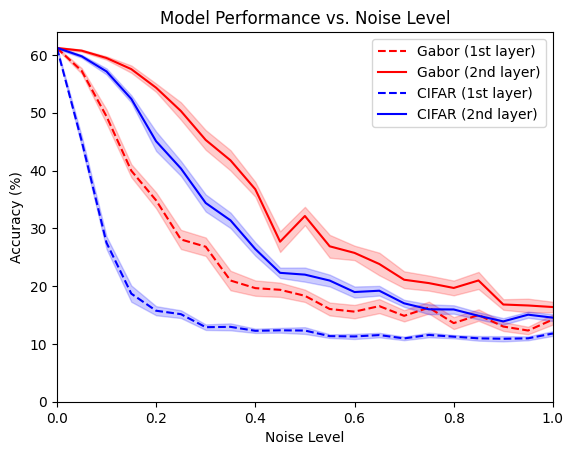

In [41]:
import seaborn as sns

sns.lineplot(
    data=noise_results_df, 
    x='noise_level', 
    y='noisy1_gabor_acc', 
    err_style='band',
    errorbar='se',
    markers='o',
    linestyle='--',
    color='red',
    label='Gabor (1st layer)'
    )

sns.lineplot(
    data=noise_results_df, 
    x='noise_level', 
    y='noisy2_gabor_acc', 
    err_style='band',
    errorbar='se',
    markers='o',
    color='red',
    label='Gabor (2nd layer)'
    )

sns.lineplot(
    data=noise_results_df, 
    x='noise_level', 
    y='noisy1_cifar_acc', 
    err_style='band',
    errorbar='se',
    color='blue',
    linestyle='--',
    label='CIFAR (1st layer)'
    )

sns.lineplot(
    data=noise_results_df, 
    x='noise_level', 
    y='noisy2_cifar_acc', 
    err_style='band',
    errorbar='se',
    color='blue',
    label='CIFAR (2nd layer)'
    )

plt.xlabel('Noise Level')
plt.ylabel('Accuracy (%)')
plt.title('Model Performance vs. Noise Level')
# plt.legend(['Gabor Accuracy', '', 'CIFAR Accuracy', ''])
plt.legend()
plt.xlim(0, 1)
plt.ylim(bottom=0)

In [42]:
pct_change_dfs = []

for i in range(10):
    temp_df = noise_results_df[noise_results_df['idx'] == i]
    temp_df['noisy1_gabor_pctchange'] = (temp_df['noisy1_gabor_acc'] - temp_df['noisy1_gabor_acc'].iloc[0]) / temp_df['noisy1_gabor_acc'].iloc[0] * 100
    temp_df['noisy2_gabor_pctchange'] = (temp_df['noisy2_gabor_acc'] - temp_df['noisy2_gabor_acc'].iloc[0]) / temp_df['noisy2_gabor_acc'].iloc[0] * 100
    temp_df['noisy1_cifar_pctchange'] = (temp_df['noisy1_cifar_acc'] - temp_df['noisy1_cifar_acc'].iloc[0]) / temp_df['noisy1_cifar_acc'].iloc[0] * 100
    temp_df['noisy2_cifar_pctchange'] = (temp_df['noisy2_cifar_acc'] - temp_df['noisy2_cifar_acc'].iloc[0]) / temp_df['noisy2_cifar_acc'].iloc[0] * 100

    pct_change_dfs.append(temp_df)

pct_change_df = pd.concat(pct_change_dfs)

/tmp/ipykernel_285353/3439499917.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['noisy1_gabor_pctchange'] = (temp_df['noisy1_gabor_acc'] - temp_df['noisy1_gabor_acc'].iloc[0]) / temp_df['noisy1_gabor_acc'].iloc[0] * 100
/tmp/ipykernel_285353/3439499917.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['noisy2_gabor_pctchange'] = (temp_df['noisy2_gabor_acc'] - temp_df['noisy2_gabor_acc'].iloc[0]) / temp_df['noisy2_gabor_acc'].iloc[0] * 100
/tmp/ipykernel_285353/3439499917.py:7: Setting

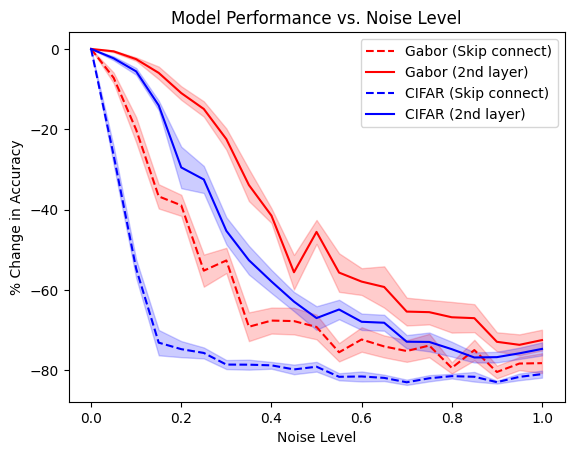

In [44]:
import seaborn as sns

sns.lineplot(
    data=pct_change_df, 
    x='noise_level', 
    y='noisy1_gabor_pctchange', 
    err_style='band',
    errorbar='se',
    markers='o',
    linestyle='--',
    color='red',
    label='Gabor (Skip connect)'
    )

sns.lineplot(
    data=pct_change_df, 
    x='noise_level', 
    y='noisy2_gabor_pctchange', 
    err_style='band',
    errorbar='se',
    markers='o',
    color='red',
    label='Gabor (2nd layer)'
    )

sns.lineplot(
    data=pct_change_df, 
    x='noise_level', 
    y='noisy1_cifar_pctchange', 
    err_style='band',
    errorbar='se',
    color='blue',
    linestyle='--',
    label='CIFAR (Skip connect)'
    )

sns.lineplot(
    data=pct_change_df, 
    x='noise_level', 
    y='noisy2_cifar_pctchange', 
    err_style='band',
    errorbar='se',
    color='blue',
    label='CIFAR (2nd layer)'
    )

plt.xlabel('Noise Level')
plt.ylabel('% Change in Accuracy')
plt.title('Model Performance vs. Noise Level')
# plt.legend(['Gabor Accuracy', '', 'CIFAR Accuracy', ''])
plt.legend()
# plt.xlim(0, 1)
# plt.ylim(bottom=-10)